## Load all required packages

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np 
from sklearn import mixture
import gensim
from cleantext import clean
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics.pairwise import cosine_similarity
# from dlutils import dlutils
import inspect
import string
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import inspect

## Load data

In [2]:

# input_dir_raw = 'data/heise'
# input_file = os.path.join(os.path.abspath(input_dir_raw), 'heise.txt')
# print(input_file)
# with open(input_file, 'r', encoding='utf-8') as file:
#     input_ = file.readlines()
    
df = pd.read_csv('data/sample_5000.csv')
input_ = df.text.values

## Define preprocess function and PVTM class

In [3]:
# from gensim.models.doc2vec import TaggedDocument, Doc2Vec
class Documents(object):
    """
    """
    
    def __init__(self, documents):
        self.documents = documents

    def __iter__(self):
        for i, doc in enumerate(self.documents):
            yield gensim.models.doc2vec.TaggedDocument(words=doc, tags=[i])
            
# x_docs = Documents(cleaned_texts)

model = gensim.models.Doc2Vec(vector_size=100,
                dbow_words=1,
                dm=0,
                epochs=1,
                window=5,
                seed=123,
                min_count=5,
                workers=6,
                alpha=0.025,
                min_alpha=0.025)

In [4]:

class PVTM(Documents):
    
    def __init__(self, texts, preprocess=True, **kwargs):        
        if preprocess==True:
            texts, vocab = self.preprocess(texts, **kwargs)
        x = [kk.split() for kk in texts]
        Documents.__init__(self,x)
        self.x_docs = Documents(x)
    def get_allowed_vocab(self,data, min_df=0.05, max_df=0.95):
        """
        Takes a list of strings.
        Result is a vocabulary based on the corpora from the input dataset.
        Pre-filtering is done using sklearns tfidfVectorizer with settings for min_df and max_df.
        """
        print(min_df, max_df)
        vec = TfidfVectorizer(min_df=min_df, max_df=max_df)

        # fit on dataset
        vec.fit(data)
        # get vocabulary
        vocabulary = set(vec.vocabulary_.keys())
        print(len(vocabulary), 'words in the vocabulary')
        return vocabulary
    def popularity_based_prefiltering(self,data, min_df=0.05, max_df=0.95, stopwords=None):
        """popularity based pre-filtering. Ignore rare and common words. 
        Takes a list of strings as input. stopwords is a list of words if provided."""
        vocabulary = self.get_allowed_vocab(data, min_df=min_df, max_df=max_df)
        vocabulary = frozenset(vocabulary)
        if stopwords:
            stopwords = frozenset(stopwords)
        pp = []
        for i, line in enumerate(data):
            rare_removed = list(filter(lambda word: word.lower() in vocabulary, line.split()))
            if stopwords:
                stops_removed = list(filter(lambda word: word.lower() not in stopwords, rare_removed))
            pp.append(" ".join(stops_removed))
        return pp, vocabulary

    def preprocess(self,texts, **kwargs):        
        '''
        The finction takes a list of texts and removes stopwords as well as very frequent and very unfrequent words.
        The function also uses clean() function from clean-text to lowercase, 
        to remove special characters, number, currency symbols etc. 
        '''
        translator=str.maketrans('','',string.punctuation)
        texts = [text.translate(translator) for text in texts]
        texts= [clean(x, **{key: value for key, value in kwargs.items() 
                                              if key in inspect.getfullargspec(clean).args}) for x in texts]
        _input, self.vocab = self.popularity_based_prefiltering(texts,**{key: value for key, value in kwargs.items() 
                                              if key in inspect.getfullargspec(self.popularity_based_prefiltering).args}) 
        return _input, self.vocab
    
        
    def fit(self, n_range=10, alpha_value_steps = 0.002, **kwargs):    
        self.model = gensim.models.Doc2Vec(**{key: value for key, value in kwargs.items() 
                                              if key in inspect.getfullargspec(gensim.models.Doc2Vec).args})
        print('Building vocab')
        self.model.build_vocab(pvtm.x_docs)
        doc_counts = len(self.documents)
        for epoch in range(n_range):
            print("epoch " + str(epoch))
            self.model.train(pvtm.x_docs, total_examples=doc_counts, epochs=1)
            #     model.save(MODEL_SAVE_NAME)
            self.model.alpha -= alpha_value_steps
        self.gmm= mixture.GaussianMixture(**{key: value for key, value in kwargs.items() 
                                             if key in inspect.getfullargspec(mixture.GaussianMixture).args})
        print('GMM Clustering')
        self.doc_vectors=np.array(self.model.docvecs.vectors_docs)
        self.gmm.fit(self.doc_vectors)
        print('BIC: {}'.format(self.gmm.bic(self.doc_vectors)))
        print('Cluster Center Computation')
        self.cluster_center(np.array(self.model.docvecs.vectors_docs), self.gmm)
        self.document_vectors = np.array(self.model.docvecs.vectors_docs)
        self.document_topics = np.array(self.gmm.predict_proba(self.document_vectors))
    def cluster_center(self, vectors, gmm):
        """
        Approximates cluster centers for a given clustering from a GMM.
        First method only takes the topic with the highest probability per document into account.
        Averaging the document vectors per topic cluster provides the cluster center for the topic.
        Second method  approximates cluster centers for a given clustering 
        from a GMM with weighted single vectors from a certain topic.
        Returns two lists of the cluster centers.
        """
        self.clustercenter = []
        assignments = gmm.predict(vectors)
        n_components = np.unique(assignments).shape[0]
        for i in range(n_components):
            gmm_centerindexe = np.where(assignments==i, True, False)        
            self.clustercenter.append(vectors[gmm_centerindexe].mean(0))
        
        self.clustercenter_probas = []
        assignments_proba = gmm.predict_proba(vectors)
        n_components = assignments_proba.shape[1] 
        for i in range(n_components):
            center = []
            for j in range(len(vectors)):
                center_j = vectors[j]*assignments_proba[:,i][j]
                center.append(center_j)
            self.clustercenter_probas.append(np.mean(center,axis=0))
    def get_string_vector(self,string, steps=10):
        '''
        The function takes a new single string(document) and
        transforms it to vector using a pretrained model.
        '''
        vector = pvtm.model.infer_vector(string.split(), steps=steps)
        return vector
    def get_topic_weights(self, vector):
        '''
        The function takes a new new definied document vector 
        and returns a distribution of a given document over all topics.
        '''
        topic_dist= self.gmm.predict_proba([vector])
        return topic_dist
    def create_wordcloud(self,topic,n_words=100, use_probas=True): 
        """
        The function takes a number of a topic and represents 
        most common word (default=100) in a wordcloud.
        """
        if use_probas==True:
            center_probas = self.clustercenter_probas
        else:
            center_probas= self.clustercenter
        sims = cosine_similarity([center_probas[topic]], self.model.wv.vectors)
        sims = np.argsort(sims)[0][::-1]
        text = [self.model.wv.index2word[k] for k in sims[:n_words]]
        text = ', '.join(text)
        wordcloud = WordCloud(max_font_size=50, max_words=n_words, background_color="white").generate(text)
        plt.figure(figsize=(8, 6))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")

### TODO:
    
- integrate cluster center computation into fit method - **done**
- add attributes to pvtm class
    - self.document_vectors - contains the transformed document vectors - np.array - **done**
    - self.document_topics - contains the topic distribution per document - np.array **done**
    - self.n_iter_d2v - number of iterations for the doc2vec algorithm
- add methods to pvtm class
    - transform(string) - transform a given string to vector using a pretrained model **done**
    - get_topics(string) - predict topic distribution for a given string (i.e. document) **done**
- replace dlutils functions with pvtm methods (i.e. add the relevant functions from dlutils into pvtm) **done**
- generate example in example folder

----------------------------------------
- modulize code (i.e. from .ipynb to .py)
- generate nice repo structure
- create setup.py file and requirements.txt
- Add documentation
    - pvtm.readthedocs.io
- Push to PyPi

https://stackoverflow.com/questions/23430248/separating-kwargs-for-different-functions

## Create PVTM object

In [5]:
example_len = 500
stop_words = set(nltk.corpus.stopwords.words('english') + ['reuter', '\x03'])
pvtm = PVTM(input_[:example_len],
            preprocess=True, 
            min_df = 0.05, 
            max_df = 0.5, 
            stopwords = stop_words)

0.05 0.5
1258 words in the vocabulary


In [6]:
n_topics=10
pvtm.fit(vector_size=100,dbow_words=1,dm=0,epochs=1,window=5,seed=123,min_count=5,workers=6,alpha=0.025, min_alpha=0.025,
        n_components= n_topics, covariance_type='tied', verbose=1, n_init=1)

Building vocab
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
GMM Clustering
Initialization 0
  Iteration 10
Initialization converged: True
BIC: -168067.58584867913
Cluster Center Computation


In [7]:
pvtm.document_topics.shape # number of rows = number of documents; number of columns = number of topics  

(500, 10)

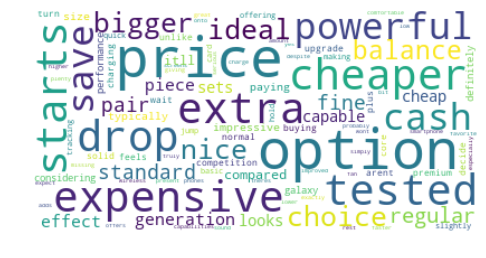

In [8]:
pvtm.create_wordcloud(6)

In [9]:
vector= 'here is a new document string'

In [10]:
test=pvtm.get_string_vector(vector)
pvtm.get_topic_weights(test)

array([[  5.60396595e-20,   3.06689574e-64,   1.00000000e+00,
          1.42158429e-31,   3.04831224e-19,   5.95177691e-58,
          2.02940019e-25,   1.51748885e-28,   5.44828035e-20,
          9.55352711e-29]])

### Get the parameters of GMM and Doc2Vec

In [11]:
# you can get all parameters used for GMM model using the following command: 
pvtm.gmm.get_params

<bound method BaseEstimator.get_params of GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=1,
        verbose_interval=10, warm_start=False, weights_init=None)>

In [12]:
# you can get all parameters used for Doc2Vec model through model attribute of PVTM object
pvtm.model.alpha
pvtm.model.epochs
pvtm.model.vector_size

0.004999999999999994

1

100

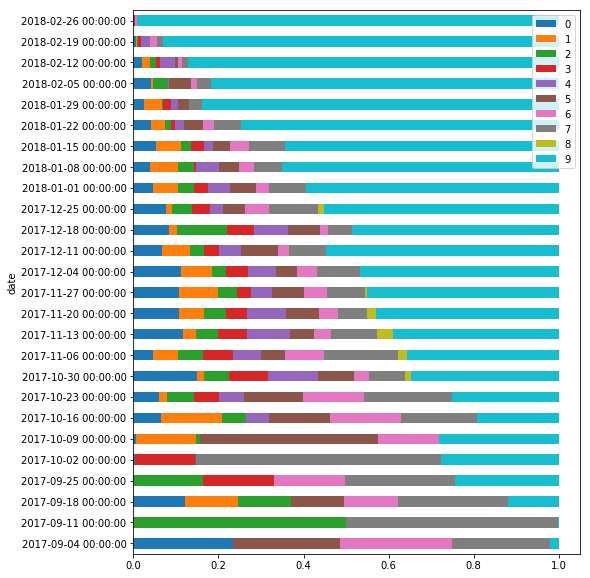

In [19]:

topic_probas = pvtm.gmm.predict_proba(pvtm.doc_vectors)
topic_probas = lda1.transform(xvecs)

df['day']= pd.to_datetime(df.date).dt.ceil('D')
df['day']= df.day.apply(lambda x: x-pd.DateOffset(weekday=0,weeks=1))
df['idx'] = df.index.values
topics_over_time = pd.DataFrame([topic_probas[row].mean(axis=0) for row in df.groupby('day').idx.apply(list).values])
topics_over_time['date'] = df.groupby('day').day.apply(list).index.values
topics_over_time['date'] = pd.to_datetime(topics_over_time['date'])
topics_over_time = topics_over_time.set_index('date')
topics_over_time.plot(kind='barh', stacked=True, figsize=(8,10))

In [13]:
topics_over_time

,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
2017-09-04 00:00:00,1.433314e-07,7.843680e-13,8.483592e-14,3.441749e-14,2.134192e-14,5.000000e-01,4.999998e-01,4.278553e-12,1.154272e-36,3.698791e-08
2017-09-04 08:52:00,9.363239e-01,2.352012e-12,1.808464e-11,5.018196e-12,6.102076e-07,5.225384e-03,5.822747e-02,8.422731e-11,4.722040e-36,2.225886e-04
2017-09-04 20:57:25,4.662820e-06,2.923956e-10,4.960771e-06,5.699985e-12,3.322456e-06,7.123919e-06,6.827693e-12,9.181714e-01,1.510514e-34,8.180854e-02
2017-09-11 03:00:10,7.141236e-06,7.350864e-13,9.989012e-01,1.402225e-11,3.974283e-10,2.967604e-04,1.698404e-14,1.049415e-08,1.897352e-43,7.949006e-04
2017-09-11 11:24:23,1.762733e-09,1.418577e-11,1.341645e-07,5.538121e-10,1.196422e-08,8.783788e-05,1.252151e-06,9.996438e-01,1.438516e-30,2.669214e-04
2017-09-18 01:33:35,1.885347e-09,2.089252e-05,7.203330e-13,1.130203e-14,1.118394e-13,8.848896e-15,9.999791e-01,4.493168e-12,9.781082e-44,1.320981e-09
2017-09-18 03:00:00,6.452621e-05,5.484504e-08,2.756817e-05,7.786131e-16,5.202679e-07,9.987945e-01,1.487063e-13,2.419552e-08,6.377134e-24,1.112845e-03
2017-09-18 04:24:34,1.611436e-08,9.999377e-01,4.048055e-08,1.056828e-12,1.493007e-11,1.476090e-07,4.732502e-13,1.201796e-06,2.094826e-37,6.090282e-05
2017-09-18 08:17:08,1.769078e-05,7.689150e-12,5.107407e-10,1.293981e-03,1.014863e-12,1.249658e-08,9.986872e-01,3.742650e-07,1.954849e-30,7.022082e-07


In [34]:
from cleantext import clean
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
    
def clean_text(text):
    return clean(text,
                fix_unicode=True,              # fix various unicode errors
                to_ascii=True,                 # transliterate to closest ASCII representation
                lower=False,                   # lowercase text
                no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
                no_urls=True,                  # replace all URLs with a special token
                no_emails=True,                # replace all email addresses with a special token
                no_phone_numbers=True,         # replace all phone numbers with a special token
                no_numbers=True,               # replace all numbers with a special token
                no_digits=True,                # replace all digits with a special token
                no_currency_symbols=True,      # replace all currency symbols with a special token
                no_punct=False,                 # fully remove punctuation
                replace_with_url="<URL>",
                replace_with_email="<EMAIL>",
                replace_with_phone_number="<PHONE>",
                replace_with_number="<NUMBER>",
                replace_with_digit="0",
                replace_with_currency_symbol="<CUR>",
                lang="en"                       # set to 'de' for German special handling
            )

   
# Load data and get tfidf vecs
x = df['text'].values[:100]
%time x = [clean_text(xx) for xx in x]
tfidf = TfidfVectorizer(min_df = 0.005, max_df = 0.5)
%time xvecs = tfidf.fit_transform(x)
print(xvecs.shape)

Wall time: 839 ms
Wall time: 47.9 ms
(100, 9120)


In [35]:
lda1 = LatentDirichletAllocation(n_components=10, max_iter=500)
%time lda1.fit(xvecs)
# get lda topic word distributions
topics1 = lda1.components_
# lda index to words
tf_feature_names = tfidf.get_feature_names()
print_top_words(lda1, tf_feature_names, 9)

Wall time: 6.76 s


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=500,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

Topic #0:
lithium porath boeing cobalt tb softbank batteries taxi mighty
Topic #1:
stranger dicamba coinhive spacex aftershow monsanto breakfast episodes satellite
Topic #2:
softbank rothenberg sprint haase telekom deutsche cryptocurrency talks merge
Topic #3:
gamestop aws kobo india oneplus election vectorized streamers server
Topic #4:
your cur game amazon he square re what said
Topic #5:
emoji pixel guacamelee xl comic con cbs burger audio
Topic #6:
echo dot zeplin figma portal region discount rallies protests
Topic #7:
sco qualcomm spacey ibm employee cargill eclipse honeysuckle turkey
Topic #8:
fitness soleri agenda tracker bronfman jr spacey sounds fitbit
Topic #9:
lifeline button invoke ccp cortana accelerator containers cap dorsey



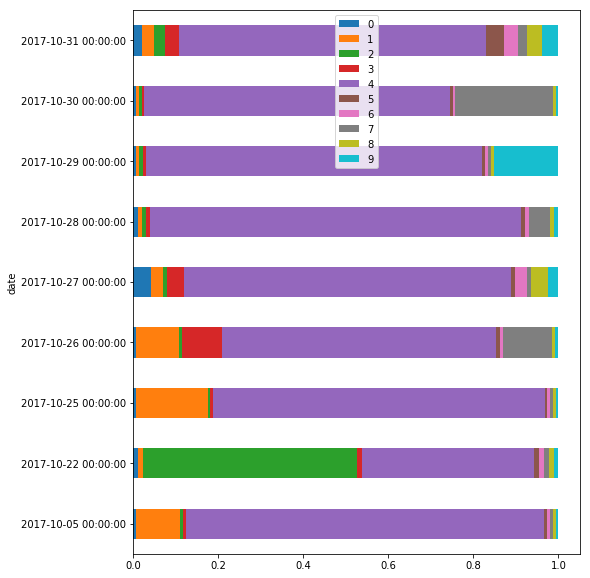

In [38]:
topic_probas = lda1.transform(xvecs)

df = df.iloc[:100]

df['day']= pd.to_datetime(df.date).dt.ceil('D')
# df['day']= df.day.apply(lambda x: x-pd.DateOffset(weekday=0,weeks=1))
df['idx'] = df.index.values
topics_over_time = pd.DataFrame([topic_probas[row].mean(axis=0) for row in df.groupby('day').idx.apply(list).values])
topics_over_time['date'] = df.groupby('day').day.apply(list).index.values
topics_over_time['date'] = pd.to_datetime(topics_over_time['date'])
topics_over_time = topics_over_time.set_index('date')
topics_over_time.plot(kind='barh', stacked=True, figsize=(8,10))